This module we'll be looking at the New York City tree census. This data was provided by a volunteer driven census in 2015, and we'll be accessing it via the socrata API. The main site for the data is [here](https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh), and on the upper right hand side you'll be able to see the link to the API.

The data is conveniently available in json format, so we should be able to just read it directly in to Pandas:

In [2]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
import pandas as pd

import numpy as np

import jupyterlab_dash


In [2]:
url = 'https://data.cityofnewyork.us/resource/nwxe-4ae8.json'
trees = pd.read_json(url)
trees.head(10)

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council_district,census_tract,bin,bbl
0,180683,348711,2015-08-27,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.723092,-73.844215,1.027431e+06,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,200540,315986,2015-09-03,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.794111,-73.818679,1.034456e+06,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,204026,218365,2015-09-05,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.717581,-73.936608,1.001823e+06,200716.8913,34.0,449.0,3338310.0,3.028870e+09
3,204337,217969,2015-09-05,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.713537,-73.934456,1.002420e+06,199244.2531,34.0,449.0,3338342.0,3.029250e+09
4,189565,223043,2015-08-30,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,3016500,New York,40.666778,-73.975979,9.909138e+05,182202.4260,39.0,165.0,3025654.0,3.010850e+09
5,190422,106099,2015-08-30,11,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,1014500,New York,40.770046,-73.984950,9.884187e+05,219825.5227,3.0,145.0,1076229.0,1.011310e+09
6,190426,106099,2015-08-30,11,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,1014500,New York,40.770210,-73.985338,9.883112e+05,219885.2785,3.0,145.0,1076229.0,1.011310e+09
7,208649,103940,2015-09-07,9,0,OnCurb,Alive,Good,Tilia americana,American linden,...,1012700,New York,40.762724,-73.987297,9.877691e+05,217157.8561,3.0,133.0,1086093.0,1.010410e+09
8,209610,407443,2015-09-08,6,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,5006400,New York,40.596579,-74.076255,9.630732e+05,156635.5542,NaN,NaN,NaN,NaN
9,192755,207508,2015-08-31,21,0,OffsetFromCurb,Alive,Fair,Platanus x acerifolia,London planetree,...,3037402,New York,40.586357,-73.969744,9.926537e+05,152903.6306,47.0,37402.0,3320727.0,3.072350e+09


Looks good, but lets take a look at the shape of this data:

In [3]:
trees.shape

(1000, 45)

1000 seems like too few trees for a city like New York, and a suspiciously round number. What's going on?

Socrata places a 1000 row limit on their API. Raw data is meant to be "paged" through for applications, with the expectation that a UX wouldn't be able to handle a full dataset. 

As a simple example, if we had a mobile app with limited space that only displayed trees 5 at a time, we could view the first 5 trees in the dataset with the url below:

In [4]:
firstfive_url = 'https://data.cityofnewyork.us/resource/nwxe-4ae8.json?$limit=5&$offset=0'
firstfive_trees = pd.read_json(firstfive_url)
firstfive_trees

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council_district,census_tract,bin,bbl
0,180683,348711,2015-08-27,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29,739,4052307,4022210001
1,200540,315986,2015-09-03,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,19,973,4101931,4044750045
2,204026,218365,2015-09-05,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,34,449,3338310,3028870001
3,204337,217969,2015-09-05,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.713537,-73.934456,1002420.358,199244.2531,34,449,3338342,3029250001
4,189565,223043,2015-08-30,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,3016500,New York,40.666778,-73.975979,990913.775,182202.4260,39,165,3025654,3010850052


If we wanted the next 5, we would use this url:

In [5]:
nextfive_url = 'https://data.cityofnewyork.us/resource/nwxe-4ae8.json?$limit=5&$offset=5'
nextfive_trees = pd.read_json(nextfive_url)
nextfive_trees

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council_district,census_tract,bin,bbl
0,190422,106099,2015-08-30,11,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,1014500,New York,40.770046,-73.984950,988418.6997,219825.5227,3.0,145.0,1076229.0,1.011310e+09
1,190426,106099,2015-08-30,11,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,1014500,New York,40.770210,-73.985338,988311.1900,219885.2785,3.0,145.0,1076229.0,1.011310e+09
2,208649,103940,2015-09-07,9,0,OnCurb,Alive,Good,Tilia americana,American linden,...,1012700,New York,40.762724,-73.987297,987769.1163,217157.8561,3.0,133.0,1086093.0,1.010410e+09
3,209610,407443,2015-09-08,6,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,5006400,New York,40.596579,-74.076255,963073.1998,156635.5542,NaN,NaN,NaN,NaN
4,192755,207508,2015-08-31,21,0,OffsetFromCurb,Alive,Fair,Platanus x acerifolia,London planetree,...,3037402,New York,40.586357,-73.969744,992653.7253,152903.6306,47.0,37402.0,3320727.0,3.072350e+09


You can read more about paging using the Socrata API [here](https://dev.socrata.com/docs/paging.html)

In these docs, you'll also see more advanced functions (called `SoQL`) under the "filtering and query" section. These functions should be reminding you of SQL.

Think about the shape you want your data to be in before querying it. Using `SoQL` is a good way to avoid the limits of the API. For example, using the below query I can easily obtain the count of each species of tree in the Bronx:

In [6]:
boro = 'Bronx'
soql_url = ('https://data.cityofnewyork.us/resource/nwxe-4ae8.json?' +\
        '$select=spc_common,count(tree_id)' +\
        '&$where=boroname=\'Bronx\'' +\
        '&$group=spc_common').replace(' ', '%20')
soql_trees = pd.read_json(soql_url)

soql_trees

,count_tree_id,spc_common
0,4619,NaN
1,43,black walnut
2,9,spruce
3,62,tulip-poplar
4,7,trident maple
...,...,...
128,195,crimson king maple
129,774,purple-leaf plum
130,363,sawtooth oak
131,505,willow oak


This behavior is very common with web APIs, and I think this is useful when thinking about building interactive data products. When in a Jupyter Notebook or RStudio, there's an expectation that (unless you're dealing with truly large datasets) the data you want can be brought in memory and manipulated.

Dash and Shiny abstract away the need to distinguish between client side and server side to make web development more accessible to data scientists. This can lead to some unintentional design mistakes if you don't think about how costly your callback functions are (for example: nothing will stop you in dash from running a costly model triggered whenever a dropdown is called.)

The goal of using the Socrata is to force you to think about where your data operations are happening, and not resort to pulling in the data and performing all operations in local memory.

----------

**NOTE**: One tip in dealing with URLs: you may need to replace spaces with `'%20'`. I personally just write out the url and then follow the string with a replace:

In [7]:
'https://api-url.com/?query with spaces'.replace(' ', '%20')

'https://api-url.com/?query%20with%20spaces'

## Assignment 4


In this module we’ll be looking at data from the New York City tree census:

https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh

This data is collected by volunteers across the city, and is meant to catalog information about every single tree in the city.

Build a dash app for a arborist studying the health of various tree species (as defined by the variable ‘spc_common’) across each borough (defined by the variable ‘borough’). This arborist would like to answer the following two questions for each species and in each borough:

1.) What proportion of trees are in good, fair, or poor health according to the ‘health’ variable?  

2.) Are stewards (steward activity measured by the ‘steward’ variable) having an impact on the health of trees?  

Please see the accompanying notebook for an introduction and some notes on the Socrata API.

Deployment:​ Dash deployment is more complicated than deploying shiny apps, so deployment in this case is ​optional ​(and will result in extra credit). You can read instructions on deploying a dash app to heroku here: ​https://dash.plot.ly/deployment


My strategy for querying was to perform multiple queries under the limit of 1000 results, then append the separate dataframes into a single tall dataframe. This avoided using the offset function of the API. After looking at unique values, I found that there were 133 unique trees, 5 boroughs, 4 levels of stewardship – including ‘None’ – and three levels of health. To keep iterations at a minimum, I chose to iterate over boroughs which also conveniently had a numeric ‘borocode’ column to iterate over.  I also filtered each query by living trees, as the variables we’re interested in only exist for living trees. 

Unfortunately, I had to perform one additional separation by stewardship level as some boroughs had slightly over 1000 combinations of unique trees, stewardship, and health. The next easiest feature to iterate over I found was stewardship, which I separated as having the value ‘None’ or any other value. In all, I queried the API 10 times for the complete dataframe. 







To answer question 1, I found the best visualization to show tree health by tree and borough was the aplty-named tree plot. In plotly, this graph already has some interactive elements, and I added a searchable dropdown to allow the user an easy way to select one of the 100+ species of trees. This also allows easily comparable proportions between boroughs and tree health. 


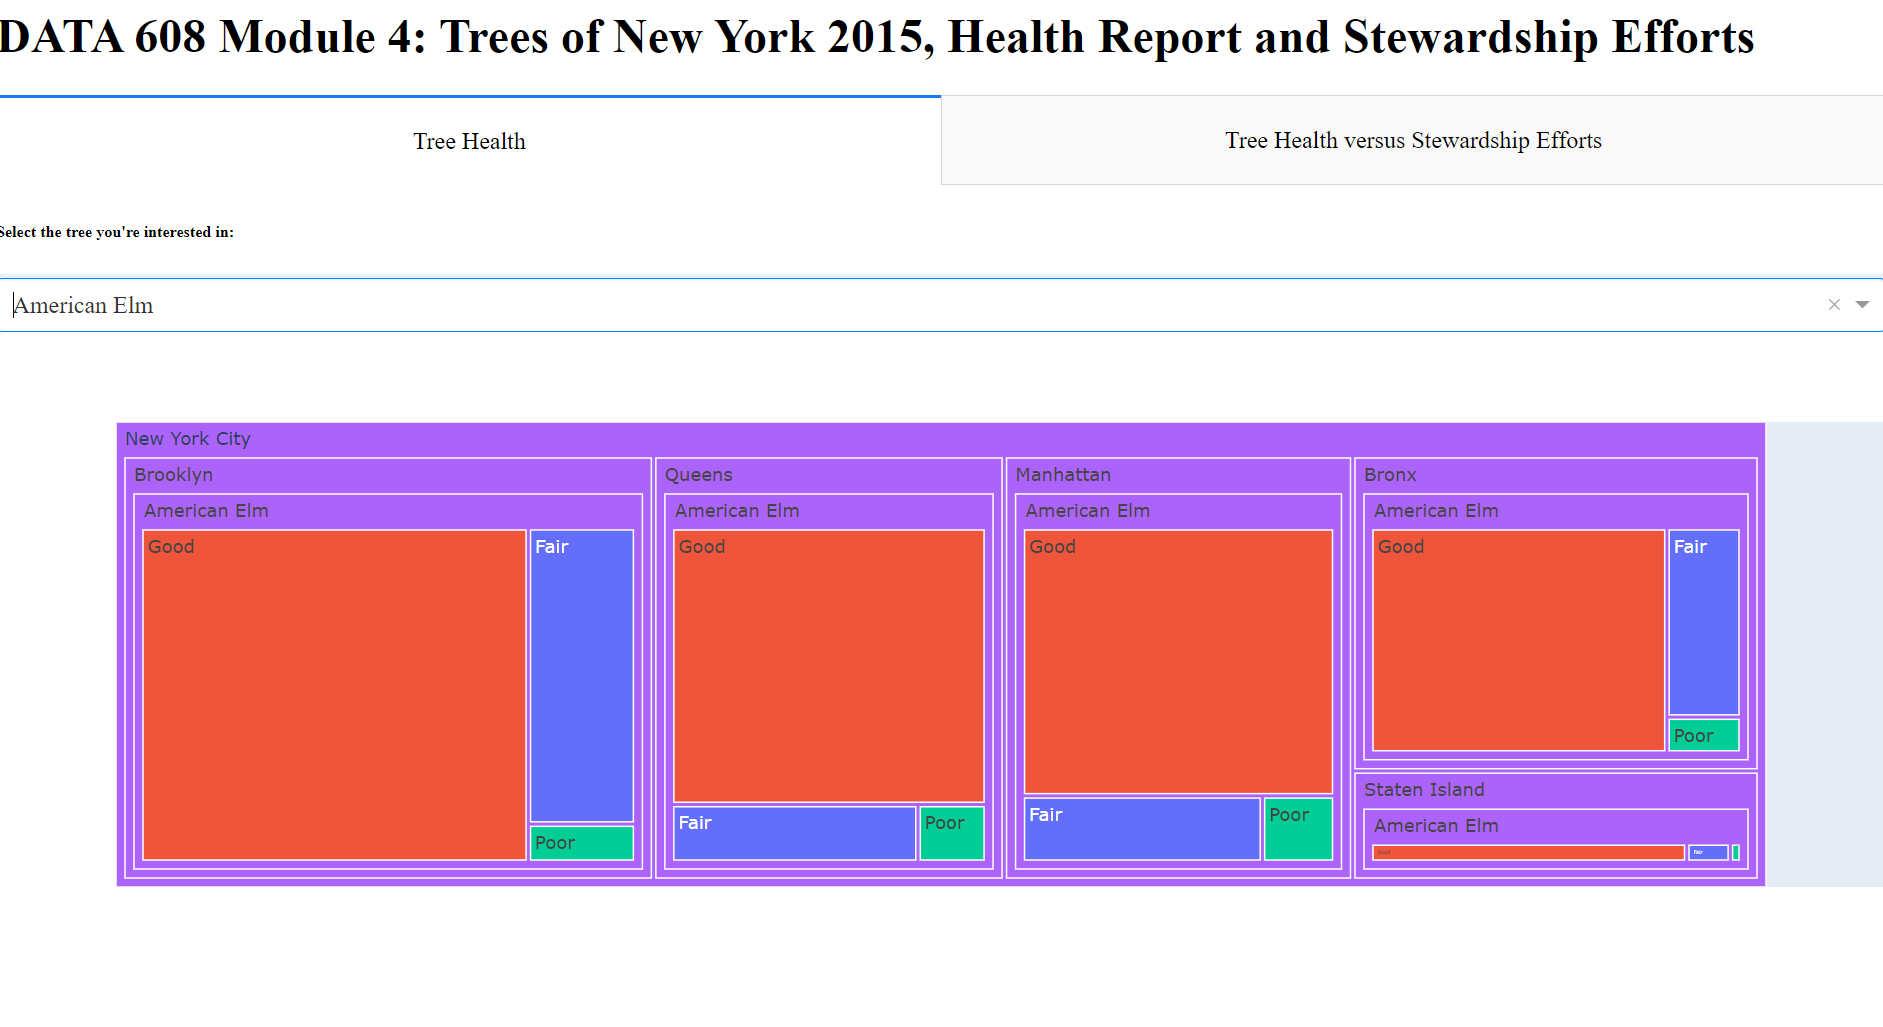

For question 2, the arborist is interested in stewardship in addition to health. Because of this, I thought it was important to allow both of these features onscreen at the same time. Two dropdowns allow the user to pick the borough and tree species, then unstacked bar graphs help visualize the effect of stewardship on tree health. Unstacked bars were important in my opinion because it allows for more direct comparison of the counts of trees in good, fair, and poor health.  


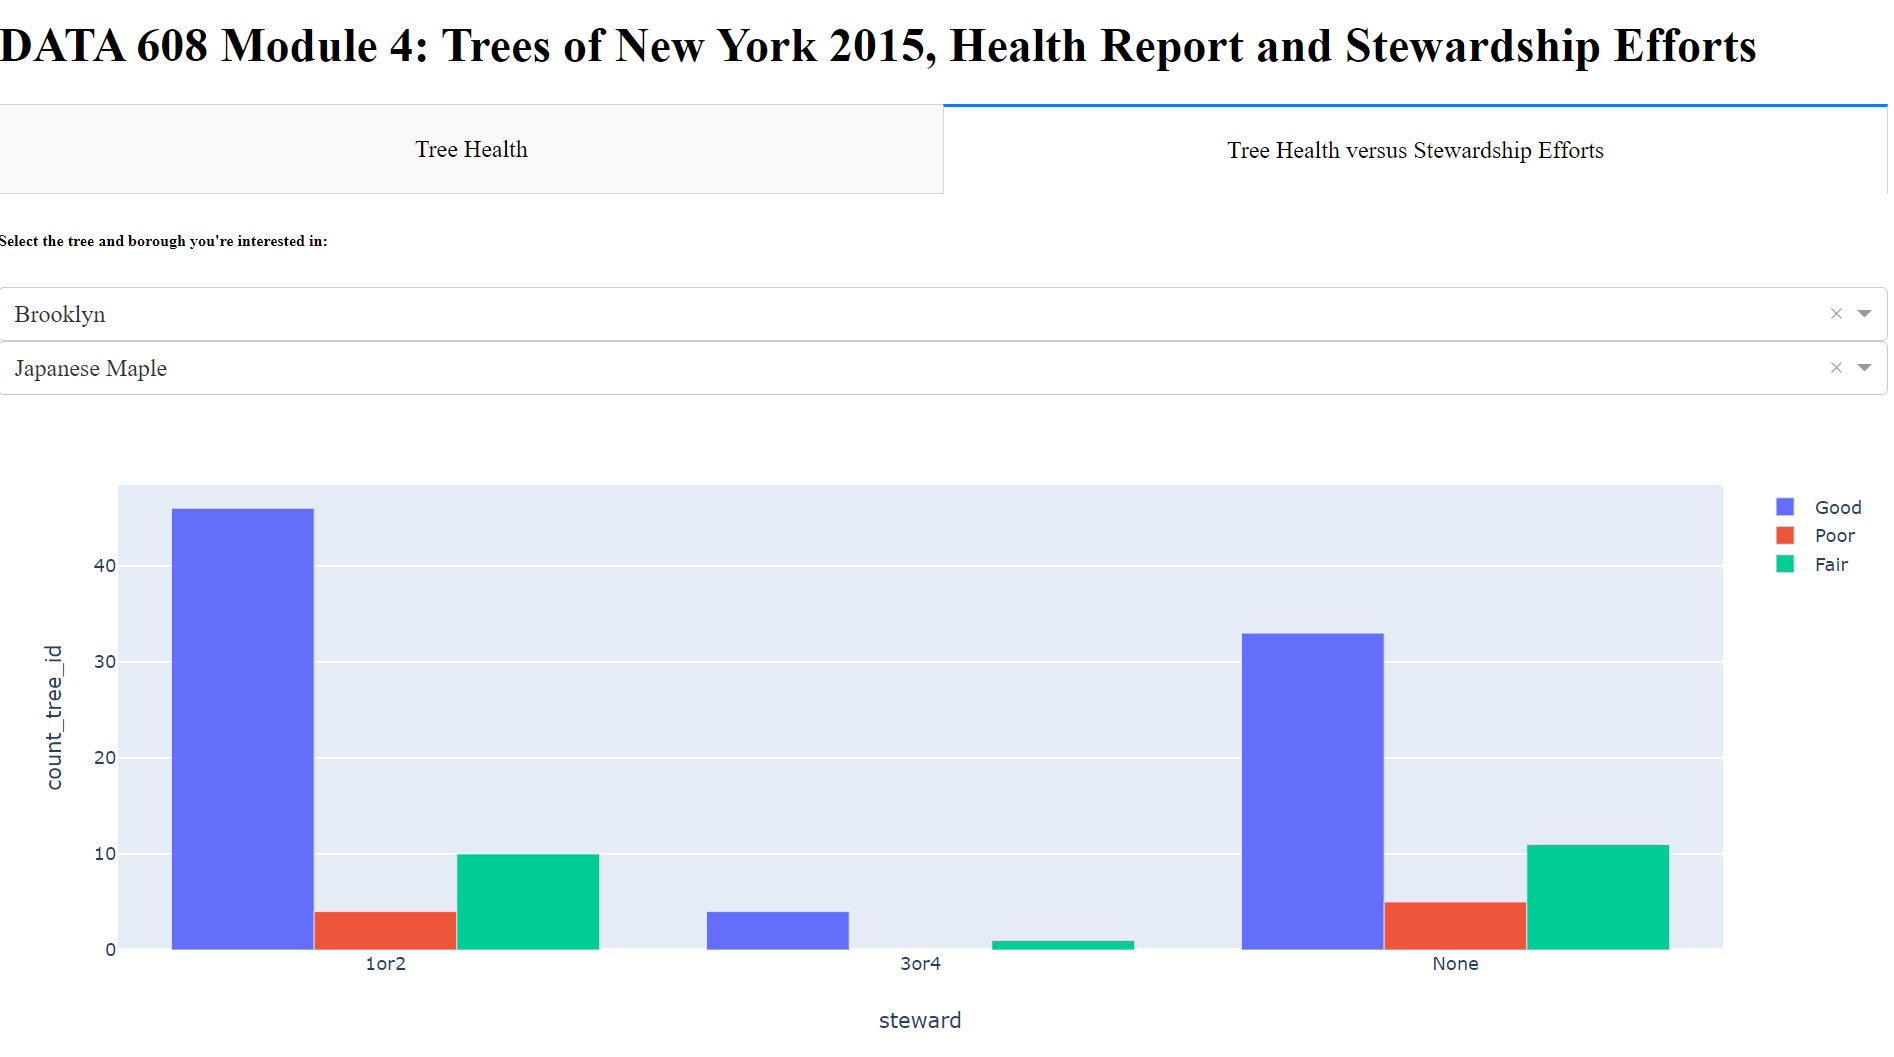

Finally, I attempted to deploy the dash app on Heroku and pythonanywhere.com, but was unsuccessful